## **Imports**

In [ ]:
#@title Imports

# Utils
import time
from tqdm import tqdm

# Data Structures
import heapq
from collections import deque

# Data Manipulation and computations
import numpy as np
import pandas as pd
import scipy.spatial.distance as dist

# Visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

## **Grid Generation and A-Star Search**

In [ ]:
#@title A* Search Utils

class Node:
  
  def __init__(self, parent=None, position=None, recency_factor=None):
    """ 
    Represents a Node in the A* search tree. 
    
    Parameters
    ----------
    parent: Node
      Node for the neighbouring cell from which this node was discovered
    position: (int, int)
      Coordinates of the cell.
    recency_factor: int
      Represents how recently this node was created. Used for breaking ties in
      the priority queue.
    """

    self.parent = parent
    self.position = position
    self.recency_factor = recency_factor

    self.g = 0
    self.h = 0
    self.f = 0
  
  def __eq__(self, other):
    """ 
    For Node comparison. 
    
    Parameters
    ----------
    other: Node
      The object with which this instance needs to be compared.
    """

    # In case 'other' is not a Node
    if type(self) != type(other):
      return False

    return self.position == other.position
  
  def __lt__(self, other):
    """ 
    For heap comparison. 
    
    Parameters
    ----------
    other: Node
      The object with which this instance needs to be compared.
    """

    if self.f < other.f:  # If priority is less
      return True
    elif self.f == other.f:  # If tie, check recency
      if self.recency_factor > other.recency_factor:
        return True
    
    return False


  def __gt__(self, other):
    """
    For heap comparison. 
    
    Parameters
    ----------
    other: Node
      The object with which this instance needs to be compared.
    """

    if self.f > other.f:  # If priority is more
      return True
    elif self.f == other.f:  # If tie, check recency
      if self.recency_factor < other.recency_factor:
        return True
    
    return False

def is_unvisited_and_unblocked(coords, state):
  """
  Checks if a cell is not blocked and not yet visited.
  
  Parameters
  ----------
  coords: (int, int)
    Coordinates of the cell to check
  state: (2D np.array, 2D np.array, 2D np.array)
    The elements are passed in the following order:
      `knowledge` - Represents the knowledge of the agent. knowledge[x][y] = 1 if
        the agent knows there exists a block at position (x, y) and is 0 otherwise.
      `visited` - Represents which nodes the agent has already expanded. visited[x][y] = 1 if
        the agent has already expanded Node at (x, y) and 0 otherwise.
      `in_fringe` - Represents if the node is in the fringe already. in_fringe[x][y] = 1
        if Node at (x, y) is already in the fringe and 0 otherwise.

  Returns
  -------
  True if not blocked and not visited else False
  """

  # Get coordinates
  x, y = coords
  knowledge, visited, _ = state

  # Return false if cell is blocked or already visited
  if knowledge[x][y]['blocked'] or visited[x][y] != 0:
    return False

  return True

def neighbourhood(coords, num_rows, num_cols, nbhd_type="compass", parent_coords=None, sense=False):
  """
  Returns the possible neighbours of a cell. Doesn't check for visited or blocked nodes.
  Assumes the grid is between `(0, 0)` to `(num_rows-1, num_cols-1)`. 

  Parameters
  ----------
  coords: (int, int)
    Coordinates of the cell
  num_rows: int
    No. of rows in the grid.
  num_cols: int
    No. of columns in the grid.
  nbhd_type: str
    `compass` - the agent can see in all 4 directions (up, down, left, right)
    `directional` - the agent can only see in the direction in which it is moving
  parent_coords: (int, int)
    Coordinates of the parent cell, required if `nbhd_type` is `directional`.

  Returns
  -------
  possible_cells: List[(int, int)]
    List of coordinates for the possible neighbours
  """

  if nbhd_type == "compass":

    # Get possible cells
    x, y = coords
    possible_cells = [(x+1, y), (x, y+1), (x-1, y), (x, y-1)]

    if sense:
      possible_cells = [(x + 1, y), (x + 1, y + 1), (x, y + 1), (x - 1, y + 1), (x - 1, y), (x - 1, y - 1), (x, y - 1), (x + 1, y - 1)]
    # Remove cells outside boundaries
    possible_cells = [cell for cell in possible_cells if cell[0] >= 0 and cell[1] >= 0 and cell[0] <= num_rows-1 and cell[1] <= num_cols-1]

    return possible_cells
  
  elif nbhd_type == "directional":

    if parent_coords is None:
      raise ValueError("Parent coords cannot be none if nbhd_type == 'directional'.")

    # Find the possible neighbouring node in the field of view
    cell = tuple(np.array(coords) + (np.array(coords) - np.array(parent_coords)))

    # Check if the node is valid
    possible_cells = [cell] if cell[0] >= 0 and cell[1] >= 0 and cell[0] <= num_rows-1 and cell[1] <= num_cols-1 else []

    return possible_cells
  
  raise ValueError("nbhd type can only be from ['compass', 'directional'], not", nbhd_type)

def get_valid_children(coords, parent, num_rows, num_cols, state):
  """
  Gets valid children for a cell, based on position, known blockages and visited
  neighbours.

  Parameters
  ----------
  coords: (int, int)
    Coordinates of the cell
  parent: Node
    Parent of the cell for which the neighbours need to be created
  num_rows: int
    No. of rows in the grid.
  num_cols: int
    No. of columns in the grid.
  state: (2D np.array, 2D np.array, 2D np.array)
    The elements are passed in the following order:
      `knowledge` - Represents the knowledge of the agent. knowledge[x][y] = 1 if
        the agent knows there exists a block at position (x, y) and is 0 otherwise.
      `visited` - Represents which nodes the agent has already expanded. visited[x][y] = 1 if
        the agent has already expanded Node at (x, y) and 0 otherwise.
      `in_fringe` - Represents if the node is in the fringe already. in_fringe[x][y] = 1
        if Node at (x, y) is already in the fringe and 0 otherwise.

  Returns
  -------
  valid_children: List[(int, int)]
    List of the possible coordinates of the children.
  """

  # Get all possible children
  nbhd = neighbourhood(coords, num_rows, num_cols)

  # Don't add the parent to the list of valid children
  if parent is not None:
    nbhd = [x for x in nbhd if x != parent.position]

  # Remove known blocked and visited cells
  valid_children = [cell for cell in nbhd if is_unvisited_and_unblocked(cell, state)]

  return valid_children

In [ ]:
#@title Generate Gridworld

def generate_gridworld(shape, block_prob):
  """
  Parameters
  ----------
  shape: (int, int)
    Number of rows and columns in the required gridworld
  block_prob: float
    Each cell is blocked with a probability p = block_prob

  Returns
  -------
  grid_world: 2D np.array
    Grid with each cell blocked with a probability `block_prob`.
  """

  num_rows, num_cols = shape

  # Randomly sample a 2D array with each cell being either 1 or 0 with prob as block_prob
  grid_world = np.random.choice([1, 0], (num_rows, num_cols), p=[block_prob, 1-block_prob])

  # Exclude start and end cells
  grid_world[0][0] = 0
  grid_world[num_rows-1][num_cols-1] = 0

  return grid_world

In [ ]:
#@title A* Search

def grid_path(current_node):
    """ 
    Recursively finds the path from the leaf to the root node in the A* search tree. 
    
    Parameters
    ----------
    current_node: Node
      Node in the A* search tree.

    Returns
    -------
    planned_path: List[(int, int)]
      Path from the root node to this leaf node
    """

    path = []

    # Recursively travel up to the root
    current = current_node

    while current != None:
      path.append(current.position)
      current = current.parent

    # Reverse and return
    return path[::-1]
  
def heuristic(name, start, end):
    """ 
    Returns the heuristic (distance) between the start and end cells. 

    Parameters
    ----------
    name: str
      Can be `'euclidean'`, `'manhattan'`, or `'chebyshev'`.
    start: (int, int)
      Coordinates of the start cell
    end: (int, int)
      Coordinates of the end cell

    Returns
    -------
    distance: float or int
      Distance based on which heuristic is being used.
    """

    if name == "euclidean":
      return dist.euclidean(start, end)
    elif name == "manhattan":
      return dist.cityblock(start, end)
    elif name == "chebyshev":
      return dist.chebyshev(start, end)

    # If heuristic is unknown, raise error
    raise NotImplementedError("Unknown heuristic:", name)


def a_star_search(start, goal, grid, heuristic_type, 
                  visited, knowledge, max_steps=None, 
                  epsilon=1.):
  """ 
  Executes A* search on a grid.

  Parameters
  ----------
  start: (int, int)
    Coordinates of the start cell.
  goal: (int, int)
    Coordinates of the goal cell.
  grid: 2D np.array
    Represents the original grid on which A* needs to be executed
  heuristic_type: str
    Type of heuristic to use. Can be `'euclidean'`, `'manhattan'`, or `'chebyshev'`
  visited: 2D np.array
    Represents which nodes the agent has already expanded. visited[x][y] = 1 if
    the agent has already expanded Node at (x, y) and 0 otherwise.
  knowledge: 2D np.array
    Represents the knowledge of the agent. knowledge[x][y] = 1 if
    the agent knows there exists a block at position (x, y) and is 0 otherwise.
  max_steps: int or None
    Max. number of times we pop a Node from the Fringe
  epsilon: float
    Weight given to the heuristic function while calculating the priority f. Used as:
    f(n) = g(n) + epsilon*h(n)

  Returns
  -------
  planned_path: List[(int, int)]
    List of cells to traverse from the start node to end node
  exit_status: str
    `"SUCCESS"` - If A* was successfully completed
    `"FAILED_NOPATH"` - If no path can be found from the start to the goal cells
    `"FAILED_STEPS"` - Max. number of steps was reached and path not found
  num_cells_propped: int
    Total number of nodes popped from the fringe throughout the search process.
  
  TODO
  ----
  - num_cells_popped == steps? Remove num_cells_popped and use steps instead
  - Remove the `grid` parameter since this is not required
  - Implement a separate `Fringe` class
  """
  start_node = Node(position=start)
  goal_node = Node(position=goal)

  # Implementing priority queue using heap
  fringe = []
  in_fringe = np.zeros(grid.shape)
  heapq.heapify(fringe)

  # Initialize tracking parameters
  recency_counter = 0
  num_cells_popped = 0

  # Add start node to the fringe
  start_node.recency_factor = recency_counter
  heapq.heappush(fringe, start_node)
  in_fringe[start[0]][start[1]] = 1
  recency_counter += 1
  
  # Stopping condition
  if max_steps is None:
    max_steps = grid.shape[0] * grid.shape[1]

  steps = 0
  exit_status = "FAILED_NOPATH"

  # Start
  while fringe:
    
    steps += 1

    # Pop the current node from the fringe
    current_node = heapq.heappop(fringe)
    num_cells_popped += 1
    curr_x, curr_y = current_node.position

    # Visit the current node and note that it is out of the fringe
    visited[curr_x][curr_y] = 1
    in_fringe[curr_x][curr_y] = 0

    # Check and return path if we have reached the goal node
    if current_node == goal_node:
      exit_status = "SUCCESS"
      return grid_path(current_node), exit_status, num_cells_popped

    # Stopping condition
    if steps > max_steps:
      exit_status = "FAILED_STEPS"
      return grid_path(current_node), exit_status, num_cells_popped

    # Create children
    children = get_valid_children(current_node.position, current_node.parent, grid.shape[0], grid.shape[1], (knowledge, visited, in_fringe))
    children = [Node(current_node, x) for x in children]

    # Set parameters for each child
    for i in range(len(children)):
      children[i].g = current_node.g + 1
      children[i].h = heuristic(heuristic_type, children[i].position, goal)
      children[i].f = children[i].g + epsilon*children[i].h
      children[i].recency_factor = recency_counter

      heapq.heappush(fringe, children[i])
      in_fringe[children[i].position[0]][children[i].position[1]] = 1

      recency_counter += 1

  return [], exit_status, num_cells_popped

In [ ]:
#@title Visualize Grid

def visualize_grid(sol, grid):
  """
  Visualize grid with the solution on top of it, marked by `*`.

  Parameters
  ----------
  sol: List[(int, int)]
    List of cells in the path from the start to end node
  grid: 2D np.array
    Grid on which to superimpose the solution

  Returns
  -------
  vis_grid: 2D np.array
    The grid to visualize. Use with `pretty_print`.
  """

  # Create copy of the original grid
  vis_grid = grid.copy().astype(str)

  # Mark path on grid
  for cell in sol:
    vis_grid[cell[0]][cell[1]] = "*"

  return vis_grid

def pretty_print(A):
  """
  Prints a 2D np.array with good visual clarity
  
  Parameters
  ----------
  A: 2D np.array
    The grid to visualize
  """
  print('\n'.join([''.join(['{:4}'.format(item) for item in row]) for row in A]))

In [ ]:
#@title Test A* Search Custom

def test_a_star_search_custom():
  grid = [[0, 1, 0, 1, 0, 0, 1, 0, 0, 0],
          [0, 1, 0, 1, 1, 0, 1, 0, 0, 0],
          [0, 1, 1, 1, 0, 0, 0, 0, 1, 0],
          [0, 1, 0, 0, 0, 1, 0, 1, 1, 0],
          [0, 1, 0, 1, 1, 0, 1, 1, 0, 0],
          [0, 1, 0, 1, 0, 0, 1, 0, 0, 1],
          [0, 1, 0, 1, 0, 0, 0, 0, 0, 0],
          [0, 1, 0, 1, 1, 0, 1, 0, 0, 1],
          [0, 0, 0, 1, 1, 0, 1, 0, 0, 0],
          [1, 1, 0, 1, 0, 0, 0, 0, 1, 0]]

  grid = np.array(grid)

  visited = np.zeros(grid.shape)
  blocked = grid.copy()

  sol = a_star_search((0, 0), (grid.shape[0]-1, grid.shape[1]-1), grid, "euclidean", visited, blocked)

  pretty_print(grid)
  print("\n")
  pretty_print(visualize_grid(sol, grid))

In [ ]:
#@title Open Cell

def is_open_cell(cell, knowledge):
  """
  Checks if a cell is open, i.e., has 3 or more unblocked neighbours.

  Parameters
  ----------
  cell: (int, int)
    Coordinates of the cell for which to check
  knowledge: 2D np.array
    Represents the knowledge of the agent. knowledge[x][y] = 1 if
    the agent knows there exists a block at position (x, y) and is 0 otherwise.
  """

  # Get neighbourhood of the cell
  nbhd = neighbourhood(cell, knowledge.shape[0], knowledge.shape[1])

  # Retain only the unblocked ones
  unblocked = [nbr for nbr in nbhd if knowledge[nbr[0]][nbr[1]] != 1]

  # Check length of unblocked cells
  if len(unblocked) >= 3:
    return True

  return False

## **Example Inference Engine**

In [ ]:
def update_knowledge_base(knowledge, cell, new_state):
  """
    Updates the knowledge of the cell based on the inferences/observations made  
    Returns the new updated knowledge base
    
    Parameters
    ----------
     knowledge: 2D array
        Represents the observed environment
    cell: (int, int)
        Coordinates of the cell for which to check
    new: dictionary
        Represents the changed states
    
    Returns
    -------
    knowledge: 2D array
        Updated knowledge base with new information about the cell gained by inference/observation
    """
  x, y = cell

  for k, v in new_state.items():
    knowledge[x][y][k] = v

  # re-adjusting hidden cells
  if not knowledge[x][y]['blocked']:
    knowledge[x][y]['h_x'] = knowledge[x][y]['n_x'] - knowledge[x][y]['b_x'] - knowledge[x][y]['e_x']


def example_inference_engine(cell, knowledge, path_tail):
    """
    Agent infers based on the collect data according to the defined rules (given ahead)
    Updates the knowledge base
    Returns a boolean about if the next step can be taken
    Parameters
    ----------
    cell: (int, int)
        Coordinates of the cell for which to check
    knowledge: 2D array
        Represents the original environment
    path_tail: 1D np.array
        Represents the remaining planned path to goal from `cell` 
    
    Returns
    -------
    knowledge: 2D array
        Updated knowledge base with new information gained by inference
    move_ahead: bool
        True if we can go ahead in the path, False if the path ahead is blocked
    """

    # inference queue = all nodes to infer with changes
    inference_fringe = deque([cell])
    in_fringe = np.zeros((len(knowledge), (len(knowledge))))
    in_fringe[cell[0]][cell[1]] = 1

    while len(inference_fringe) > 0:
      
      cell_to_infer = inference_fringe.popleft()

      nbhd = neighbourhood(cell_to_infer, len(knowledge), len(knowledge), sense=True)
      x, y = cell_to_infer

      # when the cell is blocked
      if knowledge[x][y]['blocked']:
        continue

      # getting fresh data for this cell from inferences made on other cells 
      empty_confirmed_count = 0
      blocked_confirmed_count = 0

      for nb in nbhd:

        nb_x, nb_y = nb

        if knowledge[nb_x][nb_y]['state'] == 1:
          blocked_confirmed_count += 1
        if knowledge[nb_x][nb_y]['state'] == 0:
          empty_confirmed_count += 1

      update_knowledge_base(knowledge, cell_to_infer, {'b_x':blocked_confirmed_count, 'e_x':empty_confirmed_count})

      for trail in path_tail:

        t_x, t_y = trail
        
        if knowledge[t_x][t_y]['blocked'] == True:
          return False
      
      #rule1- all remaining hidden neighbors of x are empty.
      if knowledge[x][y]['c_x'] == knowledge[x][y]['b_x']:
        new_state = dict(e_x=(knowledge[x][y]['n_x'] - knowledge[x][y]['b_x']), visited=True)
        update_knowledge_base(knowledge, cell, new_state)

        for i in nbhd:
          if (knowledge[i[0]][i[1]]['blocked']):
            continue
          if (knowledge[i[0]][i[1]]['visited']) and (knowledge[i[0]][i[1]]['h_x']>0) and (in_fringe[i[0]][i[1]] != 1):
            inference_fringe.append(i)
            in_fringe[i[0]][i[1]] = 1
            # print(f'adding {i} to fringe')
          
          if knowledge[i[0]][i[1]]['state'] == -1:
            # updating all neighbouring cells that are hidden to empty and also updating that the parent is empty
            update_knowledge_base(knowledge, i, dict(state=0, blocked=False))
            for j in neighbourhood(i, len(knowledge), len(knowledge), sense=True):
              if (knowledge[j[0]][j[1]]['visited']) and (in_fringe[j[0]][j[1]] != 1) :
                inference_fringe.append(j)
                in_fringe[j[0]][j[1]] = 1

      #rule2 - all remaining cells are blocked
      if (knowledge[x][y]['n_x'] - knowledge[x][y]['c_x']) == knowledge[x][y]['e_x']:
        new_state = dict(b_x=(knowledge[x][y]['n_x'] - knowledge[x][y]['e_x']), visited=True)
        update_knowledge_base(knowledge, cell, new_state)
        
        for i in nbhd:
          if (knowledge[i[0]][i[1]]['blocked']):
            continue

          if (knowledge[i[0]][i[1]]['visited']) and (knowledge[i[0]][i[1]]['h_x']>0) and (in_fringe[i[0]][i[1]] != 1):
            inference_fringe.append(i)
            in_fringe[i[0]][i[1]] = 1

          if knowledge[i[0]][i[1]]['state'] == -1:
            # updating all neighbouring cells that are hidden to blocked and also updating that the parent is empty  
            update_knowledge_base(knowledge, i, dict(state=1, blocked=True, e_x= (knowledge[i[0]][i[1]]['e_x'] + 1)))
            for j in neighbourhood(i, len(knowledge), len(knowledge), sense=True):
              if (knowledge[j[0]][j[1]]['visited']) and (in_fringe[j[0]][j[1]] != 1) :
                inference_fringe.append(j)
                in_fringe[j[0]][j[1]] = 1
      in_fringe[cell[0]][cell[1]] = 0

      # #rule 3- if Hx=0, nothing to be inferred
      # change=False #to see if anything new was inferred
      # if knowledge[x][y]['h_x'] == 0:
      #   # don't add neighbourhood to queue as there are no changes 
      #   continue
    
    


    return True

In [ ]:
def sense_and_update(cell, grid, knowledge):
    """
    Senses around a cell 
    Gets the count of the number of cells and count of the sensed blocked cells around it
    Updates the knowledge with this information
    Parameters
    ----------
    cell: (int, int)
        Coordinates of the cell for which to check
    grid: 2D np.array
        Represents the original environment
    grid: 2D np.array
        Represents the original environment
        
    Returns
    -------
    knowledge: 2D array
        Updated knowledge base with new information collected by the agent using its partial visibility characteristic.
    infer: Boolean
        Did we get any information to even run the inference
    """
    
    x, y = cell
    
    if knowledge[x][y]['h_x'] == 0 or knowledge[x][y]['visited']:
      return False

    # Get possible cells - east, south-east, south, south-west, west, north-west, north, north-east - all 8 directions
    possible_cells = [(x + 1, y), (x + 1, y + 1), (x, y + 1), (x - 1, y + 1), (x - 1, y), (x - 1, y - 1), (x, y - 1), (x + 1, y - 1)]
    
    num_rows, num_cols = grid.shape

    # Get count of neighbouring cells and blocked cells 
    nbhd_count = 0 
    sensed_blocked_count = 0
    empty_confirmed_count = 0
    blocked_confirmed_count = 0
    hidden_count = 0
    for p_cell in possible_cells:
        if (0 <= p_cell[0] <= num_rows - 1) and (0 <= p_cell[1] <= num_cols - 1):
            nbhd_count += 1
            if knowledge[p_cell[0]][p_cell[1]]['state'] == 0:
              empty_confirmed_count += 1
            if knowledge[p_cell[0]][p_cell[1]]['state'] == 1:
              blocked_confirmed_count += 1
            if grid[p_cell[0]][p_cell[1]] == 1:
              sensed_blocked_count += 1
    
    # updating the knowledge base with the discovered information
    new_state = dict(n_x=nbhd_count, c_x=sensed_blocked_count, e_x=empty_confirmed_count, b_x=blocked_confirmed_count, visited=True, blocked=False, state=0)
    update_knowledge_base(knowledge, cell, new_state)
    return True



## **Planning Stage**

In [ ]:
def print_inferred_cells(knowledge):
  for i in range(len(knowledge)):
    for j in range(len(knowledge)):
      if knowledge[i][j]['state'] == 1:
        print('inferred/sensed blocked at', i, j)
      if knowledge[i][j]['state'] == 0:
        print('inferred/sensed empty at', i, j)
  
def move_and_record(start, goal, grid, planned_path, knowledge, nbhd_type="compass"):
    """
    Moves the robot along the path and records the environment as it travels.
    If a block is encountered, returns the last unblocked location.

    Parameters
    ----------
    start: (int, int)
        The start coordinates in the grid. Between (0, 0) and
        (grid.shape[0]-1, grid.shape[1]-1).
    goal: (int, int)
        The goal coordinates in the grid. Limits are similar to start.
    planned_path: List[(int, int)]
        List of coordinates (including start and end) to visit.
    knowledge: 2D np.array
        Represents the knowledge of the agent. knowledge[x][y] = 1 if
        the agent knows there exists a block at position (x, y) and is 0 otherwise.
    nbhd_type: str
      `'compass'` if the agent can see in all 4 directions while moving and
      `'directional'` if the agent can see only in the direction it is moving in

    Returns
    -------
    final_node: (int, int)
        The last unblocked node visited or the goal node.
    knowledge: 2D np.array
        Updated knowledge array.
    steps: int
        Number of steps taken along the path.
    last_open_cell: (int, int)
        The last cell seen with no. of unblocked neighbours >= 3
    """

    if not planned_path:  # Planned path is empty
        raise ValueError("Planned path cannot be empty.")

    if planned_path[0] != start:  # Planned path and start don't coincide
        raise ValueError("Planned path doesn't start with 'start'! planned_path[0] =",
                         planned_path[0], "start =", start)

    steps = 0
    
    last_open_cell = None
    move_ahead = True
    bumped = False

    # Start moving
    for i in range(len(planned_path)):
        cell = planned_path[i]

        # If cell is blocked, return the last known location
        if grid[cell[0]][cell[1]] == 1:

            new_state = dict(visited=False, blocked=True, state=1)
            update_knowledge_base(knowledge, cell, new_state)

            bumped=True

            _ = example_inference_engine(cell, knowledge, planned_path[i+1:])
            return planned_path[i - 1], steps, last_open_cell,bumped

        # Collect data and update knowledge for each cell
        infer = sense_and_update(cell, grid, knowledge)

        # Call the inference engine to get updated knowledge and whether to move into replanning. 
        if infer:
            move_ahead = example_inference_engine(cell, knowledge, planned_path[i+1:])
        
        # For trajectory measuring
        steps += 1
        
        if move_ahead:
            continue
        else: 
            # Infering that something in the path is blocked
            return planned_path[i], steps, last_open_cell, bumped
          
    return planned_path[i], steps, last_open_cell,bumped

In [ ]:
class RepeatedAStar:

  def __init__(self, grid, move_nbhd_type="compass", epsilon=1., 
               escape_tunnels=False):
    """ 
    Implements the Repeated A* algorithm on a grid-world. 
    
    Parameters
    ----------
    grid: 2D np.array
      The grid world on which we need to implement the algorithm
    move_nbhd_type: str
      Can be 'compass' (see in all 4 directions in the execution phase) 
      or 'directional' (see in only the direction of the movement 
      in the execution phase)
    epsilon: float
      Weight with which the heuristic function is multiplied, as:
      f(n) = g(n) + epsilon*h(n)
    escape_tunnels: bool
      Set to true to restart A* from the start of a tunnel by backtracking
      instead of dead-ends
    """

    # Logging
    self.knowledge_snaps = []
    self.visited_snaps = []
    self.start_end_snaps = []
    self.sol_snaps = []
    self.step = 0
    self.successfully_completed = False
    self.final_exit_status = None
    self.grid = grid
    self.total_cells_processed_by_run = []
    self.backtracks = []
    self.bumps=0

    # Algorithm parameters
    self.epsilon = epsilon
    self.move_nbhd_type = move_nbhd_type
    self.escape_tunnels = escape_tunnels

    # Logging at step level
    self.stepwise_knowledge_snaps = []
    self.stepwise_actions = []
    self.stepwise_positions = []

  def _update_state(self, knowledge, visited, path_end_points, soln, 
                    step, successfully_completed, final_exit_status, 
                    num_cells_popped):
    """ 
    Updates the state (logging variables) after each run of the planning + execution phases. 
    
    Parameters
    ----------
    knowledge: 2D np.array
      Represents the knowledge of the agent. knowledge[x][y] = 1 if
      the agent knows there exists a block at position (x, y) and is 0 otherwise.
    visited: 2D np.array
      Represents which nodes the agent has already expanded. visited[x][y] = 1 if
      the agent has already expanded Node at (x, y) and 0 otherwise.
    path_end_points: ((int, int), (int, int))
      Start and end points for 1 run of A* search
    soln: List[(int, int)]
      Planned path from the start node to the end node for 1 run of A* search
    step: int
      The step number for repeated A* search
    successfully_completed: bool
      If goal node has been reached by repeated A* search
    final_exit_status: str
      `"SUCCESS"` - If A* was successfully completed
      `"RUNNING"` - If Repeated A* search is still running
      `"FAILED_NOPATH"` - A* search could not find a path between the start and end nodes
      `"FAILED_STEPS"` - No. of steps in 1 run of A* search exceeded max steps
      `"FAILED_STEPS_REP"` - No. of steps for repeated A* search exceeded max steps
    num_cells_popped: int
      Number of cells popped during one run of A* search

    TODO
    ----
    - Add backtracks to the final path
    """
    
    self.knowledge_snaps.append(knowledge)
    self.visited_snaps.append(visited)
    self.start_end_snaps.append(path_end_points)
    self.sol_snaps.append(soln)
    self.step = step
    self.successfully_completed = successfully_completed
    self.final_exit_status = final_exit_status
    self.total_cells_processed_by_run.append(num_cells_popped)


  def _stepwise_update_state(self, 
                             stepwise_knowledge_snaps_recent, 
                             stepwise_actions_recent, 
                             stepwise_positions_recent):
    
    self.stepwise_knowledge_snaps += stepwise_knowledge_snaps_recent
    self.stepwise_actions += stepwise_actions_recent
    self.stepwise_positions += self.stepwise_positions_recent

  def logs(self):
    """
    Fetches all the logging parameters

    Returns
    -------
    log: Dict[str, Any]
      All logging vars added to a dictionary
    """
    return {
        "grid": self.grid,
        "knowledge": self.knowledge_snaps,
        "visited": self.visited_snaps,
        "start_end": self.start_end_snaps,
        "solns": self.sol_snaps,
        "num_steps": self.step,
        "successfully_completed": self.successfully_completed,
        "final_exit_status": self.final_exit_status
    }

  def path_followed(self):
    """ Returns the actual path followed (planning + execution) """

    # If the paths followed and solutions don't match
    assert len(self.sol_snaps) == len(self.start_end_snaps), \
      "More steps for A* than elements in start_end."
    
    full_path = []
    for i in range(len(self.start_end_snaps)):

      # Get index of end node in path
      _, end_node = self.start_end_snaps[i]
      end_index = self.sol_snaps[i].index(end_node)

      # Clip the array according to end index and append to parent array
      clipped_array = self.sol_snaps[i][:end_index]
      full_path += clipped_array

    return full_path

  def total_cells_processed(self):
    """
    Returns total number of Nodes popped from the Fringe across each run of A* search.
    """
    
    return sum(self.total_cells_processed_by_run)

  def total_backtracked_cells(self):
    """ 
    Returns total number of cells backtracked to the start of a tunnel.
    """

    flat_list = [item for sublist in self.backtracks for item in sublist]
    return len(flat_list)

  def search(self, start, goal, grid, heuristic_type, 
             max_steps_astar=None, max_steps_repeated=None):
    """
    Performs the repeated search on a grid.

    Parameters
    ----------
    start: (int, int)
      Coordinates of the start node
    goal: (int, int)
      Coordinates of the goal node
    grid: 2D np.array
      Original gridworld on which to perform grid search
    heuristic_type: str
      Can be `'euclidean'`, `'manhattan'`, or `'chebyshev'`
    max_steps_astar: int
      Max. no. of steps for 1 run of A* search
    max_steps_repeated: int
      Max. no. of steps for 1 run of Repeated A* search
    """

    # Exit condition
    if max_steps_repeated is None:
      max_steps_repeated = grid.shape[0]*grid.shape[1]

    # Initialize visited matrix, knowledge matrix and planned_path array    
    knowledge = []
    for i in range(grid.shape[0]):
      row = []
      for j in range(grid.shape[1]):
        row.append(dict(n_x=0, blocked=False, visited=False, state=-1, c_x=0, b_x=0, e_x=0, h_x=-1))
      knowledge.append(row)
    

    # Start
    while not self.successfully_completed:

      visited = np.zeros(grid.shape)

      # Run A* search algorithm once
      planned_path, exit_status, num_cells_popped = \
        a_star_search(start, goal, grid, heuristic_type, 
                      visited, knowledge, max_steps=max_steps_astar, 
                      epsilon=self.epsilon)
      
      # If no path can be found
      if exit_status == "FAILED_NOPATH":
        self._update_state(knowledge, visited, (start, None), 
                           planned_path, self.step + 1, False, 
                           exit_status, num_cells_popped)
        return

      # If num of steps were exceeded for one run of A*
      elif exit_status == "FAILED_STEPS":
        self._update_state(knowledge, visited, (start, None), 
                           planned_path, self.step + 1, False, 
                           exit_status, num_cells_popped)
        return

      # Move robot along the grid on the planned path and record environment
      final_node, _, last_open_cell, bumped = move_and_record(start, goal, grid, 
                                                                planned_path, knowledge, 
                                                                nbhd_type=self.move_nbhd_type)

      if bumped:
        self.bumps+=1

      # If we were able to reach the goal successfully
      if final_node == goal:
        self._update_state(knowledge, visited, (start, final_node), 
                           planned_path, self.step + 1, True, 
                           "SUCCESS", num_cells_popped)
        continue

      # If we were not able to reach the goal successfully, repeat until possible
      self._update_state(knowledge, visited, (start, final_node), 
                         planned_path, self.step + 1, False,
                         "RUNNING", num_cells_popped)
      
      # Backtracking to the start of tunnels if this parameter is set, else start from end of last path
      if self.escape_tunnels and last_open_cell is not None and final_node != last_open_cell:
        start = last_open_cell

        loc_idx = planned_path.index(last_open_cell)
        backtrack = reversed(planned_path[loc_idx:])

        self.backtracks.append(backtrack)
      else:
        start = final_node

    # We were able to reach successfully
    return

In [ ]:
l = [1, 2, 3, 4, 5, 6, 7]

last_open_cell = 3
loc_idx = l.index(last_open_cell)
backtrack = list(reversed(l[loc_idx:]))

backtrack

[7, 6, 5, 4, 3]

In [ ]:
def test_repeated_a_star_search_custom(move_nbhd_type="compass", epsilon=1., escape_tunnels=False):
  """ 
  For custom testing of the repeated A* search algorithm. The default grid presents
  a particularly difficult case for A* search. 
  
  Parameters
  ----------
  move_nbhd_type: str
    `'compass'` - Agent can see in all 4 directions while moving
    `'directional'` - Agent can only see in the direction it is moving
  epsilon: float
    Weight given to the heuristic function. Used as:
    f(n) = g(n) * epsilon*h(n)
  escape_tunnels: bool
    Escape tunnels before restarting A* search
  """
  # grid = [[0, 1, 0, 1, 0, 0, 1, 0, 0, 0],
  #         [0, 1, 0, 1, 1, 0, 1, 0, 0, 0],
  #         [0, 1, 1, 1, 0, 0, 0, 0, 1, 0],
  #         [0, 1, 0, 0, 0, 1, 0, 1, 1, 0],
  #         [0, 1, 0, 1, 1, 0, 1, 1, 0, 0],
  #         [0, 1, 0, 1, 0, 0, 1, 0, 0, 1],
  #         [0, 1, 0, 1, 0, 0, 0, 0, 0, 0],
  #         [0, 1, 0, 1, 1, 0, 1, 0, 0, 1],
  #         [0, 0, 0, 1, 1, 0, 1, 0, 0, 0],
  #         [1, 1, 0, 1, 0, 0, 0, 0, 1, 0]]

  grid = [[0, 0, 0, 0],
          [0, 1, 1, 1],
          [0, 0, 1, 0],
          [1, 0, 0, 0]]

  grid = np.array(grid)

  # Run Repeated A* on the grid
  repeated_a_star = RepeatedAStar(grid, move_nbhd_type=move_nbhd_type, epsilon=epsilon, escape_tunnels=escape_tunnels)
  repeated_a_star.search((0, 0), (grid.shape[0]-1, grid.shape[1]-1), grid, "manhattan")

  # Return the completed R.A* object
  return repeated_a_star

def test_repeated_a_star_search_random(grid_shape, block_prob, 
                                       heuristic_type="euclidean", 
                                       move_nbhd_type="compass", 
                                       solvable=True, 
                                       epsilon=1., 
                                       escape_tunnels=False,
                                       max_steps_astar=None,
                                       max_steps_repeated=None):
  """ 
  For random testing of the repeated A* search algorithm. 
  
  Parameters
  ----------
  grid_shape: (int, int)
    Shape of the randomly generated gridworld
  block_prob: float
    Each cell in the randomly generated gridworld will be blocked with p = block_prob
  heuristic_type: str
    Can be `'euclidean'`, `'manhattan'`, or `'chebyshev'`
  move_nbhd_type: str
    `'compass'` - Agent can see in all 4 directions while moving
    `'directional'` - Agent can only see in the direction it is moving
  solvable: bool
    Set to True if the randomly generated gridworld has to be solvable 
  epsilon: float
    Weight given to the heuristic function. Used as:
    f(n) = g(n) * epsilon*h(n)
  escape_tunnels: bool
    Escape tunnels before restarting A* search
  """

  grid = None

  # If the grid needs to be solvable
  if solvable:
    is_solvable = False

    # Keep generating random gridworlds until a solvable one comes up
    while not is_solvable:

      # Generate and check solvability of gridworld
      

      grid = generate_gridworld(grid_shape, block_prob=block_prob)
      knowledge = []
      for i in range(grid.shape[0]):
        row = []
        for j in range(grid.shape[1]):
          if grid[i][j] == 1:
            row.append(dict(n_x=0, blocked=True, visited=False, state=-1, c_x=0, b_x=0, e_x=0, h_x=0))
          else:
            row.append(dict(n_x=0, blocked=False, visited=False, state=-1, c_x=0, b_x=0, e_x=0, h_x=0))
        knowledge.append(row)
  
      _, exit_status, _ = a_star_search((0, 0), 
                                        (grid.shape[0]-1, grid.shape[1]-1), 
                                        grid, 
                                        heuristic_type, 
                                        np.zeros(grid.shape), 
                                        knowledge)

      # If gridworld is solvable, break out of loop
      if exit_status == "SUCCESS":
        is_solvable = True
  else:
    # Else generate a random gridworld
    grid = generate_gridworld(grid_shape, block_prob=block_prob)

  t0 = time.time()

  # Run Repeated A* on the grid
  repeated_a_star = RepeatedAStar(grid, 
                                  move_nbhd_type=move_nbhd_type, 
                                  epsilon=epsilon, 
                                  escape_tunnels=escape_tunnels)
  repeated_a_star.search((0, 0), (grid.shape[0]-1, grid.shape[1]-1), grid, heuristic_type,
                         max_steps_repeated=max_steps_repeated, max_steps_astar=max_steps_astar)

  time_taken = time.time() - t0

  # Return the completed R.A* object and the time taken
  return repeated_a_star, time_taken

## **Random Testing**

In [ ]:
%%time

NUM_ITERS = 1100
DIM_ROWS, DIM_COLS, P = 50, 50, 0.3
HEURISTIC_FN = "manhattan"

path_lengths = []
times = []

count = 0
for iter in tqdm(range(NUM_ITERS)):
    if count > 900:
        break

    try:
        ras, time_taken = test_repeated_a_star_search_random((DIM_ROWS, DIM_COLS), P, HEURISTIC_FN)
        path_lengths.append(len(ras.path_followed()))
        times.append(time_taken)

        count += 1
    except:
        continue

 83%|████████▎ | 917/1100 [04:49<00:57,  3.17it/s]

CPU times: user 4min 46s, sys: 1.48 s, total: 4min 48s
Wall time: 4min 49s


In [ ]:
len(path_lengths)

901

In [ ]:
def block_undiscovered_nodes(knowledge):
  for i in range(len(knowledge)):
    row = []
    for j in range(len(knowledge)):
      if knowledge[i][j]['state'] == -1:
        knowledge[i][j]['blocked'] = True
  return knowledge

In [ ]:

ras, _ = test_repeated_a_star_search_random((10, 10), 0.25, "manhattan")
print(np.shape(ras.knowledge_snaps))
pretty_print(ras.grid)

(6, 10, 10)
   0   0   1   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   1   0   0   0   0   0
   0   0   1   0   0   0   0   0   0   1
   0   1   0   1   0   0   0   0   0   1
   0   0   0   1   1   0   0   0   1   1
   0   0   0   0   0   1   0   1   1   0
   0   0   0   0   1   0   0   0   0   0
   0   0   1   0   1   0   0   1   0   0
   0   1   1   1   0   1   0   1   0   0


In [ ]:
pretty_print(visualize_grid(ras.path_followed(),ras.grid))
print(ras.bumps)

*   *   1   0   0   0   0   0   0   0   
0   *   *   *   *   *   *   *   *   *   
0   0   0   0   1   0   0   0   *   *   
0   0   1   0   0   0   0   0   *   1   
0   1   0   1   0   0   0   *   *   1   
0   0   0   1   1   0   *   *   1   1   
0   0   0   0   0   1   *   1   1   0   
0   0   0   0   1   0   *   *   *   *   
0   0   1   0   1   0   0   1   0   *   
0   1   1   1   0   1   0   1   0   0   
5


In [ ]:

# print(visualize_grid(ras.path_followed(),ras.grid))
print()

nk = []
new_k = block_undiscovered_nodes( ras.knowledge_snaps[-1])
for i in range(len(new_k)):
  r=[]
  for j in range(len(new_k)):
    r.append(1 if new_k[i][j]['blocked'] else 0)
  nk.append(r)
pretty_print(nk)


   0   0   1   0   1   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0
   1   0   0   0   1   0   0   0   0   0
   1   1   1   1   1   1   0   0   0   1
   1   1   1   1   1   1   0   0   0   1
   1   1   1   1   1   1   0   0   1   1
   1   1   1   1   1   1   0   1   1   1
   1   1   1   1   1   1   0   0   0   0
   1   1   1   1   1   1   1   1   0   0
   1   1   1   1   1   1   1   1   0   0


## **Agent 3 Analysis**

In [ ]:
def temp(grid):
      knowledge = []
      for i in range(grid.shape[0]):
        row = []
        for j in range(grid.shape[1]):
          if grid[i][j] == 1:
            row.append(dict(n_x=0, blocked=True, visited=False, state=-1, c_x=0, b_x=0, e_x=0, h_x=0))
          else:
            row.append(dict(n_x=0, blocked=False, visited=False, state=-1, c_x=0, b_x=0, e_x=0, h_x=0))
        knowledge.append(row)
      return knowledge

      
def q6(num_iters, dim_rows, dim_cols, densities, heuristic_fn, max_steps_astar=None, max_steps_repeated=None):

  mean_traj_lengths, mean_num_cells_processed, mean_metric_2, mean_metric_3 ,mean_time,avg_bumps=[], [], [], [], [],[]

  for i in tqdm(range(len(densities))):
    p = densities[i]

    print("P = " + str(p), end="\n")

    traj_lengths, traj_lengths_by_sp_final_discs, sp_final_disc_by_sp_fulls, num_cells_processed, time_taken,bumps = [],[], [], [], [],[]

    for i in range(num_iters):

      if i % 50 == 0: 
        print(str(i) + ": Running R-A*...", end='')

      ras, time_t = test_repeated_a_star_search_random((dim_rows, dim_cols), p, heuristic_fn, 
                                                  max_steps_repeated=max_steps_repeated, 
                                                  max_steps_astar=max_steps_astar)
      
      bumps.append(ras.bumps)
      
      new_knowledge = block_undiscovered_nodes( ras.knowledge_snaps[-1])
      
      #print('testtt', len(ras.knowledge_snaps[-1]), len(new_knowledge))
      if i % 50 == 0:
        print("SP disc...", end='')

      shortest_path_final_discovered , exit_status_final_discovered, _ = \
        a_star_search((0, 0), (ras.grid.shape[0]-1, ras.grid.shape[1]-1), 
                      ras.grid.copy(), heuristic_fn, np.zeros(ras.grid.shape), 
                      new_knowledge)
        

      new_knowledge = temp(ras.grid) 
      if i % 50 == 0:
        print("SP disc full...", end='')

      shortest_path_full, exit_status_full, _ = \
        a_star_search((0, 0), (ras.grid.shape[0]-1, ras.grid.shape[1]-1), 
                      ras.grid.copy(), heuristic_fn, np.zeros(ras.grid.shape), 
                      new_knowledge)
        
      if i % 50 == 0:
        print("Done.")

      try:
        trajectory_length = len(ras.path_followed())  # Metric 1
      except:
        print("Skipped!")
        continue
      if len(shortest_path_final_discovered)<19:
        print("Mischievious path length",len(shortest_path_final_discovered) )
        print(shortest_path_final_discovered)
        break
        #pretty_print(visualize_grid(ras.path_followed(),ras.grid))
      traj_length_by_sp_final_disc = trajectory_length/len(shortest_path_final_discovered)  # Metric 2
      sp_final_disc_by_sp_full = len(shortest_path_final_discovered)  # Metric 3
      total_cells_processed = ras.total_cells_processed()  # Metric 4
      

      traj_lengths.append(trajectory_length)
      traj_lengths_by_sp_final_discs.append(traj_length_by_sp_final_disc)
      sp_final_disc_by_sp_fulls.append(sp_final_disc_by_sp_full)
      num_cells_processed.append(total_cells_processed)
      time_taken.append(time_t)#metric 5

    mean_traj_lengths.append(np.mean(traj_lengths))
    mean_num_cells_processed.append(np.mean(num_cells_processed))
    mean_metric_2.append(np.mean(traj_lengths_by_sp_final_discs))
    mean_metric_3.append(np.mean(sp_final_disc_by_sp_fulls))
    mean_time.append(np.mean(time_taken))
    avg_bumps.append(np.mean(bumps))

  df_res = pd.DataFrame({"p": densities, 
                         "mean_trajectory_lengths": mean_traj_lengths, 
                         "mean_metric_2": mean_metric_2, 
                         "final_path_length_discovered": mean_metric_3,
                         "mean_num_cells_processed": mean_num_cells_processed,
                         "time_taken":mean_time,
                         "mean_bumps":avg_bumps})
  
  return df_res

In [ ]:
NUM_ITERS = 10
DIM_ROWS, DIM_COLS, P0 = 101, 101, 0.29
DENSITIES = np.arange(0.0, 0.33, 0.01)
HEURISTIC_FN = "manhattan"

NUM_STEPS_INF = 532643263

df = q6(NUM_ITERS, DIM_ROWS, DIM_COLS, DENSITIES, HEURISTIC_FN, 
        max_steps_astar=None, max_steps_repeated=None)



  0%|          | 0/33 [00:00<?, ?it/s]

P = 0.0
0: Running R-A*...SP disc...SP disc full...Done.


  3%|▎         | 1/33 [00:01<00:34,  1.07s/it]

P = 0.01
0: Running R-A*...SP disc...SP disc full...Done.


  6%|▌         | 2/33 [00:02<00:37,  1.22s/it]

P = 0.02
0: Running R-A*...SP disc...SP disc full...Done.


  9%|▉         | 3/33 [00:03<00:41,  1.37s/it]

P = 0.03
0: Running R-A*...SP disc...SP disc full...Done.


 12%|█▏        | 4/33 [00:05<00:46,  1.61s/it]

P = 0.04
0: Running R-A*...SP disc...SP disc full...Done.


 15%|█▌        | 5/33 [00:07<00:48,  1.73s/it]

P = 0.05
0: Running R-A*...SP disc...SP disc full...Done.


 18%|█▊        | 6/33 [00:10<00:52,  1.93s/it]

P = 0.06
0: Running R-A*...SP disc...SP disc full...Done.


 21%|██        | 7/33 [00:12<00:54,  2.09s/it]

P = 0.07
0: Running R-A*...SP disc...SP disc full...Done.


 24%|██▍       | 8/33 [00:15<00:55,  2.22s/it]

P = 0.08
0: Running R-A*...SP disc...SP disc full...Done.


 27%|██▋       | 9/33 [00:18<00:59,  2.47s/it]

P = 0.09
0: Running R-A*...SP disc...SP disc full...Done.


 30%|███       | 10/33 [00:21<01:02,  2.70s/it]

P = 0.1
0: Running R-A*...SP disc...SP disc full...Done.


 33%|███▎      | 11/33 [00:24<01:03,  2.88s/it]

P = 0.11
0: Running R-A*...SP disc...SP disc full...Done.


 36%|███▋      | 12/33 [00:28<01:05,  3.13s/it]

P = 0.12
0: Running R-A*...SP disc...SP disc full...Done.


 39%|███▉      | 13/33 [00:32<01:07,  3.37s/it]

P = 0.13
0: Running R-A*...SP disc...SP disc full...Done.


 42%|████▏     | 14/33 [00:36<01:08,  3.59s/it]

P = 0.14
0: Running R-A*...SP disc...SP disc full...Done.


 45%|████▌     | 15/33 [00:40<01:09,  3.85s/it]

P = 0.15
0: Running R-A*...SP disc...SP disc full...Done.


 48%|████▊     | 16/33 [00:45<01:07,  3.97s/it]

P = 0.16
0: Running R-A*...SP disc...SP disc full...Done.


 52%|█████▏    | 17/33 [00:50<01:10,  4.41s/it]

P = 0.17
0: Running R-A*...SP disc...SP disc full...Done.


 55%|█████▍    | 18/33 [00:55<01:10,  4.72s/it]

P = 0.18
0: Running R-A*...SP disc...SP disc full...Done.


 58%|█████▊    | 19/33 [01:02<01:12,  5.21s/it]

P = 0.19
0: Running R-A*...SP disc...SP disc full...Done.


 61%|██████    | 20/33 [01:09<01:13,  5.67s/it]

P = 0.2
0: Running R-A*...SP disc...SP disc full...Done.


 64%|██████▎   | 21/33 [01:15<01:09,  5.76s/it]

P = 0.21
0: Running R-A*...SP disc...SP disc full...Done.


 67%|██████▋   | 22/33 [01:21<01:05,  5.97s/it]

P = 0.22
0: Running R-A*...SP disc...SP disc full...Done.


 70%|██████▉   | 23/33 [01:29<01:06,  6.62s/it]

P = 0.23
0: Running R-A*...SP disc...SP disc full...Done.


 73%|███████▎  | 24/33 [01:36<01:01,  6.78s/it]

P = 0.24
0: Running R-A*...SP disc...SP disc full...Done.


 76%|███████▌  | 25/33 [01:46<01:00,  7.57s/it]

P = 0.25
0: Running R-A*...SP disc...SP disc full...Done.


 79%|███████▉  | 26/33 [01:55<00:55,  7.97s/it]

P = 0.26
0: Running R-A*...SP disc...SP disc full...Done.


 82%|████████▏ | 27/33 [02:05<00:52,  8.70s/it]

P = 0.27
0: Running R-A*...SP disc...SP disc full...Done.


 85%|████████▍ | 28/33 [02:17<00:48,  9.74s/it]

P = 0.28
0: Running R-A*...SP disc...SP disc full...Done.


 88%|████████▊ | 29/33 [02:29<00:41, 10.44s/it]

P = 0.29
0: Running R-A*...SP disc...SP disc full...Done.


 91%|█████████ | 30/33 [02:41<00:32, 10.95s/it]

P = 0.3
0: Running R-A*...SP disc...SP disc full...Done.


 94%|█████████▍| 31/33 [02:56<00:23, 11.95s/it]

P = 0.31
0: Running R-A*...SP disc...SP disc full...Done.


 97%|█████████▋| 32/33 [03:10<00:12, 12.65s/it]

P = 0.32
0: Running R-A*...SP disc...SP disc full...Done.


100%|██████████| 33/33 [03:28<00:00,  6.31s/it]


In [ ]:
df.head()

,p,mean_trajectory_lengths,mean_metric_2,final_path_length_discovered,mean_num_cells_processed,time_taken,mean_bumps
0,0.00,200.0,0.995025,201.0,201.0,0.030243,0.0
1,0.01,201.2,0.999015,201.4,413.4,0.049234,1.7
2,0.02,203.6,1.008916,201.8,490.8,0.051359,3.3
3,0.03,205.6,1.009811,203.6,819.1,0.075410,6.0
4,0.04,212.4,1.030981,206.0,1212.0,0.104525,10.0


In [ ]:
df.to_csv("agent3_metrics_bumps.csv")

## **Plot Comparisons**

In [ ]:
print(repeated_a_star.final_exit_status)
pretty_print(visualize_grid(ras.path_followed(), ras.knowledge_snaps[-1].astype(int)))

In [ ]:
def plot_line_chart(x, y, xlabel, ylabel, title=None, fig=None, ax=None):
    if not fig:
        fig, ax = plt.subplots()
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if title:
        ax.set_title(title)
    ax.plot(x, y)
    fig.show()
    return fig, ax

def plot_comparison_line_charts(x, comp, xlabel, ylabel, title=None, fig=None, ax=None):
    if not fig:
        fig, ax = plt.subplots()
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if title:
        ax.set_title(title)
    
    for i in comp:
        y, label = i
        ax.plot(x, y, label=label)
    ax.legend()
    fig.show()
    return fig, ax

In [ ]:
import pandas as pd

df_agent3=pd.read_csv("agent3_metrics_v2.csv")
df_agent3.head()
mean_traj_length_agent3=df_agent3["mean_trajectory_lengths"]
df_agent1=pd.read_csv("agent1_metrics_v2.csv")
df_agent1.head()
mean_traj_length_agent1=df_agent1["mean_trajectory_lengths"]
df_agent2=pd.read_csv("agent2_metrics_v2.csv")
df_agent2.head()
mean_traj_length_agent2=df_agent2["mean_trajectory_lengths"]


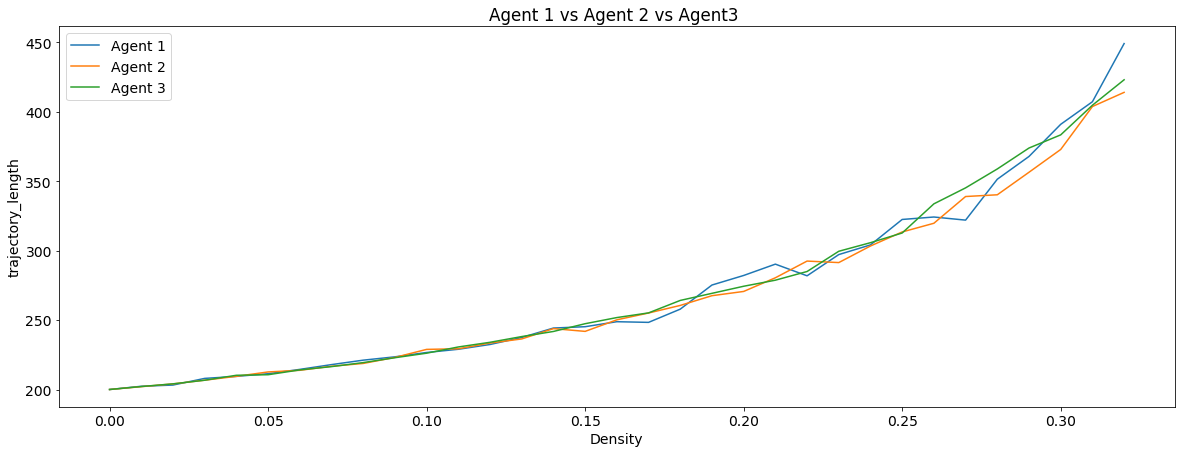

In [ ]:
# fig, ax = plt.subplots(1, 1)
plt.rcParams.update({'font.size': 14})
# df1 = df[['Probability', 'Cells Processed', 'Type']]
#pivot_df = df1.pivot(index='Type', columns='Probability', values='Cells Processed')
fig, _ =  plot_comparison_line_charts(df_agent3['p'], [ (mean_traj_length_agent1, 'Agent 1'),(mean_traj_length_agent2, 'Agent 2'),(mean_traj_length_agent3, 'Agent 3')]
                                      ,xlabel='Density', ylabel='trajectory_length', title='Agent 1 vs Agent 2 vs Agent3 ')
fig.set_size_inches(20, 7)